## Environment Setting
Google drive mount (for Colab users) and package importing.
You can optionally work on a transformer part.

In [90]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import StepLR
import torch.optim as optim
from tqdm import tqdm
import random
import json

%load_ext autoreload
%autoreload 2
from data_utils import MLDataset, collate_fn
from modeling import Seq2SeqModel


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## (Optional) Sample Visualization
You can see actual sample images and correct answers. Additional matplotlib package is needed.

In [91]:
# Just for reference: see actual samples
import matplotlib.pyplot as plt

id_to_char = {}
alphabets = "abcdefghijklmnopqrstuvwxyz"
for i, c in enumerate(alphabets):
    id_to_char[i+1] = c

Answer: orthodox ([15, 18, 20, 8, 15, 4, 15, 24])
Input image sequence:


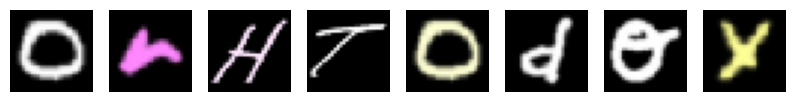

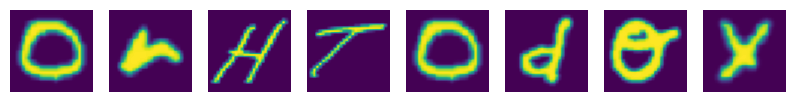

In [92]:
# Just for reference: see actual samples
idx = 60000

def get_sample(idx):
    sample = np.load(f'./data_final/imgs/train/{idx}.npy')
    with open('./data_final/labels/train.json', 'r') as f:
        sample_target = json.load(f)[str(idx)]
    return sample, sample_target

def show_sample(sample, sample_target):
    tgt_char = ""
    for i in sample_target:
        tgt_char += id_to_char[i]


    print(f"Answer: {tgt_char} ({sample_target})")
    print("Input image sequence:")

    plt.figure(figsize=(10, len(sample)))
    for i, img in enumerate(sample):
        plt.subplot(1, len(sample), i+1)
        plt.axis("off")
        plt.imshow(img)
        
        
sample, sample_target = get_sample(idx)
show_sample(sample, sample_target)


sample = sample.mean(3)[:,:,:,np.newaxis]
#print(sample.shape)
plt.figure(figsize=(10, len(sample)))
for i, img in enumerate(sample):
    plt.subplot(1, len(sample), i+1)
    plt.axis("off")
    plt.imshow(img)


## Device and seed setting

In [93]:
assert torch.cuda.is_available()

# Use 0th GPU for training
torch.cuda.set_device(0)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# fix random seed to increase reproducibility
# NOTE: Do not modify here!
NUM_CLASSES = 26 + 2 # 26 alphabets + 1 padding index + 1 <s> token (start token)

random_seed = 7
torch.manual_seed(random_seed)
os.environ['PYTHONHASHSEED'] = str(random_seed)
np.random.seed(random_seed)
random.seed(random_seed)
torch.cuda.manual_seed(random_seed)

torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True
# %env CUBLAS_WORKSPACE_CONFIG=:16:8

def seed_worker(worker_seed):
    np.random.seed(worker_seed)
    random.seed(worker_seed)

num_workers = 8

## Model loading and training

In [94]:
# NOTE: modify path and batch size for your setting
# NOTE: you can apply custom preprocessing to the training data

BATCH_SIZE = 128


train_ds = MLDataset('data_final/imgs/train', 'data_final/labels/train.json')
valid_ds = MLDataset('data_final/imgs/valid_normal', 'data_final/labels/valid_normal.json')
challenge_ds = MLDataset('data_final/imgs/valid_challenge', 'data_final/labels/valid_challenge.json')

train_dl = DataLoader(train_ds, batch_size=BATCH_SIZE, collate_fn=collate_fn, shuffle=True)
valid_dl = DataLoader(valid_ds, batch_size=BATCH_SIZE, collate_fn=collate_fn, shuffle=False)
challenge_dl = DataLoader(challenge_ds, batch_size=BATCH_SIZE, collate_fn=collate_fn, shuffle=False)


In [95]:
# You can add or modify your Seq2SeqModel's hyperparameter (keys and values)
kwargs = {
    'hidden_dim': 256,
    'n_rnn_layers': 2,
    'rnn_dropout': 0.4,
    'embedding_dim': 80

    #teacherforcing ratio
}

In [96]:
model = Seq2SeqModel(num_classes=NUM_CLASSES, **kwargs).to(device)
print(model)
##############################################################################
#                          IMPLEMENT YOUR CODE                               #
##############################################################################
model_optim = optim.Adam(model.parameters(), lr=0.003)

# Loss function
loss_fn = nn.CrossEntropyLoss(ignore_index=0)  # 0번 인덱스를 패딩으로 사용

# Scheduler
scheduler = StepLR(model_optim, step_size=1, gamma=0.9)
# NOTE: you can define additional components like lr_scheduler, ...
##############################################################################
#                          END OF YOUR CODE                                  #
##############################################################################

Seq2SeqModel(
  (encoder): Encoder(
    (cnn): CustomCNN(
      (conv1): Sequential(
        (0): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
        (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      )
      (conv2): Sequential(
        (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
        (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      )
      (conv3): Sequential(
        (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
        (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    

In [97]:
# NOTE: you can freely modify or add training hyperparameters
print_interval = 100
max_epoch = 8

In [98]:
def train(model, model_optim, loss_fn, max_epoch, train_dl, valid_dl, load_path=None, save_path='./model.pt'):
    ##############################################################################
    #                          IMPLEMENT YOUR CODE                               #
    ##############################################################################
    # Load your states
    loaded_epoch = 0
    loaded_best_valid_loss = -1
    if load_path is not None:
        state = torch.load(load_path)
        model.load_state_dict(state["model"])
        model_optim.load_state_dict(state["optimizer"])
        loaded_epoch = state["epoch"]
        loaded_best_valid_loss = state["best_valid_loss"]
        # ...

    ##############################################################################
    #                          END OF YOUR CODE                                  #
    ##############################################################################
    best_valid_loss = 1e+10 if loaded_best_valid_loss == -1 else loaded_best_valid_loss
    losses = []
    for epoch in np.array(list(range(max_epoch - loaded_epoch))) + loaded_epoch:
        step = 0
        train_loss = 0
        print_loss = 0
        model.train()
        for batch_idx, (data, target, lengths) in enumerate(tqdm(train_dl)):
            data = data.to(device) # (B, T, H, W, C)
            target = target.to(device) # (B, T)

            # start tokens should be located at the first position of the decoder input
            start_tokens = (torch.ones([target.size(0), 1]) * 27).to(torch.long).to(device)   #ind 0 is for <pad>, idx 27 is for <s>
            ##############################################################################
            #                          IMPLEMENT YOUR CODE                               #
            ##############################################################################
            # Problem 5: implement loss calculation and optimization part
            # You can utilize teacher-forcing strategy to this part

            model_optim.zero_grad()

            # Prepare decoder input (start tokens + target without last token)
            decoder_input = torch.cat([start_tokens, target[:, :-1]], dim=1) # is equal to input_sep in Decoder_forward
            # Forward pass
            output, _ = model(data, lengths, decoder_input)

            # Calculate loss
            loss = loss_fn(output.permute(0, 2, 1), target)  # (B, N_vocab, T) -> (B, T, N_vocab) vs (B, T)
            loss.backward()
            model_optim.step()


       
            ##############################################################################
            #                          END OF YOUR CODE                                  #
            ##############################################################################
            train_loss += loss.detach().cpu().item()
            step += 1
            print_loss += loss.detach().cpu().item()
            if (batch_idx + 1) % print_interval == 0:
                print('epoch:', epoch + 1, 'step:', step + 1, 'loss:', print_loss/print_interval)
                losses.append(print_loss/print_interval)
                print_loss = 0

        train_loss_avg = train_loss / (batch_idx+1)
        print(f"epoch {epoch + 1}, train loss: {train_loss_avg}")

        valid_loss = 0
        model.eval()
        for batch_idx, (data, target, lengths) in enumerate(tqdm(valid_dl)):
            with torch.no_grad():
                data = data.to(device) # (B, T, H, W, C)
                target = target.to(device) # (B, T)

                # start tokens should be located at the first position of the decoder input
                start_tokens = (torch.ones([target.size(0), 1]) * 27).to(torch.long).to(device)
                ##############################################################################
                #                          IMPLEMENT YOUR CODE                               #
                ##############################################################################
                # Implement loss calculation for valid batch (same as problem 5)
                decoder_input = torch.cat([start_tokens, target[:, :-1]], dim=1)

                # Forward pass
                output, _ = model(data, lengths, decoder_input)

                # Calculate loss
                loss = loss_fn(output.permute(0, 2, 1), target)  # (Batch_size, N_vocab, Sequence_length) vs (Batch_size, Sequence_length)
                ##############################################################################
                #                          END OF YOUR CODE                                  #
                ##############################################################################
                valid_loss += loss.cpu().item()
        valid_loss /= (batch_idx + 1)
        if valid_loss < best_valid_loss:
            print("New best valid loss, saving model")
            ##############################################################################
            #                          IMPLEMENT YOUR CODE                               #
            ##############################################################################
            # Save your states
            state = {
                "model": model.state_dict(),
                "optimizer": model_optim.state_dict(),
                "epoch": epoch + 1,
                "best_valid_loss": best_valid_loss,
                # ...
            }
            ##############################################################################
            #                          END OF YOUR CODE                                  #
            ##############################################################################
            torch.save(state, save_path)
            best_valid_loss = valid_loss
        print('valid epoch: %d, valid loss: %.4f, best valid loss: %.4f' % (epoch + 1, valid_loss, best_valid_loss))


    return losses

In [99]:
load_path = None
losses = train(model, model_optim, loss_fn, max_epoch, train_dl, valid_dl, load_path=load_path, save_path='./final_model.pt')
print(kwargs)
plt.plot(losses)

 19%|█▉        | 100/531 [01:14<05:22,  1.34it/s]

epoch: 1 step: 101 loss: 2.3192230033874512


 38%|███▊      | 200/531 [02:26<04:18,  1.28it/s]

epoch: 1 step: 201 loss: 1.584672487974167


 56%|█████▋    | 300/531 [03:39<02:50,  1.36it/s]

epoch: 1 step: 301 loss: 1.1257886677980422


 75%|███████▌  | 400/531 [04:54<01:34,  1.38it/s]

epoch: 1 step: 401 loss: 0.8561804246902466


 94%|█████████▍| 500/531 [06:07<00:23,  1.32it/s]

epoch: 1 step: 501 loss: 0.64569571018219


100%|██████████| 531/531 [06:29<00:00,  1.36it/s]


epoch 1, train loss: 1.261768606759734


100%|██████████| 76/76 [00:55<00:00,  1.36it/s]


New best valid loss, saving model
valid epoch: 1, valid loss: 0.5553, best valid loss: 0.5553


 19%|█▉        | 100/531 [01:13<05:08,  1.40it/s]

epoch: 2 step: 101 loss: 0.48649238646030424


 38%|███▊      | 200/531 [02:26<04:04,  1.35it/s]

epoch: 2 step: 201 loss: 0.42497081905603407


 56%|█████▋    | 300/531 [03:39<02:46,  1.39it/s]

epoch: 2 step: 301 loss: 0.35663514137268065


 75%|███████▌  | 400/531 [04:53<01:38,  1.33it/s]

epoch: 2 step: 401 loss: 0.3134612347185612


 94%|█████████▍| 500/531 [06:09<00:23,  1.33it/s]

epoch: 2 step: 501 loss: 0.24737794175744057


100%|██████████| 531/531 [06:31<00:00,  1.36it/s]


epoch 2, train loss: 0.356704578505173


100%|██████████| 76/76 [00:52<00:00,  1.46it/s]


New best valid loss, saving model
valid epoch: 2, valid loss: 0.2415, best valid loss: 0.2415


 19%|█▉        | 100/531 [01:14<05:02,  1.42it/s]

epoch: 3 step: 101 loss: 0.18398757845163347


 38%|███▊      | 200/531 [02:27<03:55,  1.41it/s]

epoch: 3 step: 201 loss: 0.17088346302509308


 56%|█████▋    | 300/531 [03:39<02:37,  1.46it/s]

epoch: 3 step: 301 loss: 0.15570856481790543


 75%|███████▌  | 400/531 [04:51<01:39,  1.32it/s]

epoch: 3 step: 401 loss: 0.14976261734962462


 94%|█████████▍| 500/531 [06:04<00:24,  1.25it/s]

epoch: 3 step: 501 loss: 0.14568968787789344


100%|██████████| 531/531 [06:26<00:00,  1.37it/s]


epoch 3, train loss: 0.16011262286573705


100%|██████████| 76/76 [00:54<00:00,  1.40it/s]


New best valid loss, saving model
valid epoch: 3, valid loss: 0.1753, best valid loss: 0.1753


 19%|█▉        | 100/531 [01:16<05:04,  1.41it/s]

epoch: 4 step: 101 loss: 0.11783518709242344


 38%|███▊      | 200/531 [02:29<04:06,  1.34it/s]

epoch: 4 step: 201 loss: 0.11687472961843014


 56%|█████▋    | 300/531 [03:39<02:44,  1.41it/s]

epoch: 4 step: 301 loss: 0.12357997454702854


 75%|███████▌  | 400/531 [04:48<01:26,  1.52it/s]

epoch: 4 step: 401 loss: 0.11123348772525787


 94%|█████████▍| 500/531 [05:58<00:21,  1.45it/s]

epoch: 4 step: 501 loss: 0.10765399128198623


100%|██████████| 531/531 [06:21<00:00,  1.39it/s]


epoch 4, train loss: 0.11517604231385413


100%|██████████| 76/76 [00:53<00:00,  1.42it/s]


New best valid loss, saving model
valid epoch: 4, valid loss: 0.1619, best valid loss: 0.1619


  1%|          | 4/531 [00:03<07:15,  1.21it/s]


KeyboardInterrupt: 

## Model evaluation

In [100]:
kwargs_generate = {
    # you can add arguments for your model's generate function
    'max_length': 12
}

In [101]:
# Do not modify this cell!

def eval(dataloader, model_path):
    state = torch.load(model_path)
    model.load_state_dict(state["model"])
    model.eval()

    id_to_char = {}
    id_to_char[0] = "<pad>"
    id_to_char[27] = "<s>"
    alphabets = "abcdefghijklmnopqrstuvwxyz"
    for i, c in enumerate(alphabets):
        id_to_char[i+1] = c

    results = []
    labels = []    
    for batch_idx, (data, target, lengths) in enumerate(tqdm(dataloader)):       
        data = data.to(device) # (B, T, H, W, C)
        target = target.to(device) # (B, T)
        
        # start tokens should be located at the first position of the decoder input
        start_tokens = (torch.ones([target.size(0), 1]) * 27).to(torch.long).to(device) #B, 1
        with torch.no_grad():
            generated_tok = model.generate(data, lengths, start_tokens, **kwargs_generate) # (B, T)
    #     data: (Batch_size, Sequence_length, Height, Width, Channel)
    #     lengths: (Batch_size,)
    #     start_token: (Batch_size, 1)
    
            
        for i in range(generated_tok.size(0)):
            decoded = ""
            for j in generated_tok[i][:lengths[i].int()].tolist():
                decoded += id_to_char[j]
            results.append(decoded)
    
            decoded = ""
            for j in target[i][:lengths[i].int()].tolist():
                decoded += id_to_char[j]
            labels.append(decoded)
        
    corrects = []
    for i in range(len(results)):
        if results[i] == labels[i]:
            corrects.append(1)
        else:
            corrects.append(0)
    print("Accuracy: %.5f" % (sum(corrects) / len(corrects)))

    return results, labels

In [103]:
# load and evaluate your model
load_path = './final_model.pt'
print("Evaluation with validation set")
results, labels = eval(valid_dl, load_path)

Evaluation with validation set


100%|██████████| 76/76 [04:13<00:00,  3.33s/it]

Accuracy: 0.70734
